In [38]:
from __future__ import print_function, division
import os
import torch
import numpy as np
import pandas as pd
import math
import re
import pdb
import pickle
from scipy import stats

from torch.utils.data import Dataset
import h5py

from utils.utils import generate_split, nth

from datasets.dataset_generic import Generic_WSI_Classification_Dataset, Generic_MIL_Dataset, save_splits

In [39]:
# csv_path = 'dataset_csv/fungal_vs_nonfungal.csv'
csv_path = 'dataset_csv/tumor_vs_normal_dummy_clean.csv'
shuffle = False
print_info = True
label_dict = {'normal_tissue':0, 'tumor_tissue':1}
# label_dict = {'nonfungal':0, 'fungal':1}
patient_strat=False
ignore=[]

seed = 7
filter_dict = {}
label_col = 'label'
patient_voting = 'max'

In [97]:
def patient_data_prep(patient_voting='max'):
    patients = np.unique(np.array(slide_data['case_id'])) # get unique patients
    patient_labels = []

    for p in patients:
        locations = slide_data[slide_data['case_id'] == p].index.tolist()
        assert len(locations) > 0
        label = slide_data['label'][locations].values
        if patient_voting == 'max':
            label = label.max() # get patient label (MIL convention)
        elif patient_voting == 'maj':
            label = stats.mode(label)[0]
        else:
            raise NotImplementedError
        patient_labels.append(label)

    patient_data = {'case_id':patients, 'label':np.array(patient_labels)}
    return patient_data


In [98]:
def cls_ids_prep(patient_data):
    # store ids corresponding each class at the patient or case level
    patient_cls_ids = [[] for i in range(num_classes)]
    for i in range(num_classes):
        patient_cls_ids[i] = np.where(patient_data['label'] == i)[0]

    # store ids corresponding each class at the slide level
    slide_cls_ids = [[] for i in range(num_classes)]
    for i in range(num_classes):
        slide_cls_ids[i] = np.where(slide_data['label'] == i)[0]

In [99]:
def filter_df(df, filter_dict={}):
    if len(filter_dict) > 0:
        filter_mask = np.full(len(df), True, bool)
        # assert 'label' not in filter_dict.keys()
        for key, val in filter_dict.items():
            mask = df[key].isin(val)
            filter_mask = np.logical_and(filter_mask, mask)
        df = df[filter_mask]
    return df

In [100]:
def df_prep(data, label_dict, ignore, label_col):
    if label_col != 'label':
        data['label'] = data[label_col].copy()

    mask = data['label'].isin(ignore)
    data = data[~mask]
    data.reset_index(drop=True, inplace=True)
    for i in data.index:
        key = data.loc[i, 'label']
        data.at[i, 'label'] = label_dict[key]

    return data

In [101]:
class Generic_MIL_Dataset(Generic_WSI_Classification_Dataset):
	def __init__(self,
		data_dir,
		**kwargs):

		super(Generic_MIL_Dataset, self).__init__(**kwargs)
		self.data_dir = data_dir
		self.use_h5 = False

	def load_from_h5(self, toggle):
		self.use_h5 = toggle

	def __getitem__(self, idx):
		slide_id = self.slide_data['slide_id'][idx]
		label = self.slide_data['label'][idx]
		if type(self.data_dir) == dict:
			source = self.slide_data['source'][idx]
			data_dir = self.data_dir[source]
		else:
			data_dir = self.data_dir

		if not self.use_h5:
			if self.data_dir:
				full_path = os.path.join(data_dir, 'pt_files', '{}.pt'.format(slide_id))
				features = torch.load(full_path)
				return features, label

			else:
				return slide_id, label

		else:
			full_path = os.path.join(data_dir,'h5_files','{}.h5'.format(slide_id))
			with h5py.File(full_path,'r') as hdf5_file:
				features = hdf5_file['features'][:]
				coords = hdf5_file['coords'][:]

			features = torch.from_numpy(features)
			return features, label, coords

In [102]:
class Generic_Split(Generic_MIL_Dataset):
    def __init__(self, slide_data, data_dir=None, num_classes=2):
        self.use_h5 = False
        self.slide_data = slide_data
        self.data_dir = data_dir
        self.num_classes = num_classes
        self.slide_cls_ids = [[] for i in range(self.num_classes)]
        for i in range(self.num_classes):
            self.slide_cls_ids[i] = np.where(self.slide_data['label'] == i)[0]

    def __len__(self):
        return len(self.slide_data)


In [103]:
def get_split_from_df(all_splits, split_key='train'):
    split = all_splits[split_key]
    split = split.dropna().reset_index(drop=True)

    if len(split) > 0:
        mask = slide_data['slide_id'].isin(split.tolist())
        df_slice = slide_data[mask].reset_index(drop=True)
        split = Generic_Split(df_slice, data_dir=data_dir, num_classes=num_classes)
    else:
        split = None

    return split

In [104]:
def return_splits(from_id=True, csv_path=None):


    if from_id:
        if len(train_ids) > 0:
            train_data = slide_data.loc[train_ids].reset_index(drop=True)
            train_split = Generic_Split(train_data, data_dir=data_dir, num_classes=num_classes)

        else:
            train_split = None

        if len(val_ids) > 0:
            val_data = slide_data.loc[val_ids].reset_index(drop=True)
            val_split = Generic_Split(val_data, data_dir=data_dir, num_classes=num_classes)

        else:
            val_split = None

        if len(self.test_ids) > 0:
            test_data = slide_data.loc[test_ids].reset_index(drop=True)
            test_split = Generic_Split(test_data, data_dir=data_dir, num_classes=num_classes)

        else:
            test_split = None


    else:
        assert csv_path
        all_splits = pd.read_csv(csv_path, dtype=slide_data['slide_id'].dtype)  # Without "dtype=self.slide_data['slide_id'].dtype", read_csv() will convert all-number columns to a numerical type. Even if we convert numerical columns back to objects later, we may lose zero-padding in the process; the columns must be correctly read in from the get-go. When we compare the individual train/val/test columns to self.slide_data['slide_id'] in the get_split_from_df() method, we cannot compare objects (strings) to numbers or even to incorrectly zero-padded objects/strings. An example of this breaking is shown in https://github.com/andrew-weisman/clam_analysis/tree/main/datatype_comparison_bug-2021-12-01.
        train_split = get_split_from_df(all_splits, 'train')
        val_split = get_split_from_df(all_splits, 'val')
        test_split = get_split_from_df(all_splits, 'test')

    return train_split, val_split, test_split

In [105]:
num_classes = len(set(label_dict.values()))
train_ids, val_ids, test_ids = (None, None, None)
data_dir = None
if not label_col:
	label_col = 'label'
label_col = label_col

slide_data = pd.read_csv(csv_path)
slide_data = filter_df(slide_data, filter_dict)
slide_data = df_prep(slide_data, label_dict, ignore, label_col)
print(slide_data)

###shuffle data
if shuffle:
	np.random.seed(seed)
	np.random.shuffle(slide_data)

slide_data = slide_data

patient_data = patient_data_prep(patient_voting)
cls_ids_prep(patient_data)

# if print_info:
# 	print("label column: {}".format(label_col))
# 	print("label dictionary: {}".format(label_dict))
# 	print("number of classes: {}".format(num_classes))
# 	print("slide-level counts: ", '\n', slide_data['label'].value_counts(sort = False))
# 	for i in range(num_classes):
# 		print('Patient-LVL; Number of samples registered in class %d: %d' % (i, patient_cls_ids[i].shape[0]))
# 		print('Slide-LVL; Number of samples registered in class %d: %d' % (i, slide_cls_ids[i].shape[0]))


         case_id   slide_id label
0      patient_0    slide_0     1
1      patient_0    slide_1     0
2      patient_1    slide_2     1
3      patient_2    slide_3     0
4      patient_2    slide_4     0
..           ...        ...   ...
495  patient_445  slide_495     1
496  patient_446  slide_496     0
497  patient_447  slide_497     0
498  patient_448  slide_498     0
499  patient_449  slide_499     1

[500 rows x 3 columns]


In [106]:
split_datasets = slide_data
splits = [split_datasets[i].slide_data['slide_id'] for i in range(len(split_datasets))]

print(splits)

KeyError: 0

In [40]:
import torch
import torch.nn.functional as F

logits = torch.rand([24, 1, 1, 2])
top_k = 8

y_probs = F.softmax(logits, dim = 1)
print(y_probs.shape)
print(y_probs[:, 0].shape)
top_instance_idx = torch.topk(y_probs[:, 0], top_k, dim=0)[1].view(8,2)[:,0]
print(top_instance_idx)

torch.Size([24, 1, 1, 2])
torch.Size([24, 1, 2])
tensor([18, 13, 14, 15, 16, 17, 21, 23])


In [41]:
import torch
import torch.nn.functional as F

a = torch.rand([1, 2, 4, 8, 16])

b = a.view(16,-1)
print(b.shape)

torch.Size([16, 64])


In [158]:
        # top_instance_idx = torch.topk(y_probs[:, 0], self.top_k, dim=0)[1].view(1,)self.top_k

In [42]:
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()

a = torch.Tensor([[[5., 7.]]])
b = torch.Tensor([[0.]]).long()

loss = loss_fn(a, b)

print(loss)

ValueError: Expected target size (1, 2), got torch.Size([1, 1])

In [43]:
a = torch.Tensor([[[[-19.3550,  58.1746]]]])

b = F.softmax(a, dim=3)
print(b)

tensor([[[[2.1346e-34, 1.0000e+00]]]])


In [ ]:
h = torch.rand([24, 10])
a = torch.rand([24, ])
top_k = 8

In [20]:
top_instance_idx = torch.topk(a, top_k, dim=0)[1]
print(top_instance_idx)

top_p = torch.index_select(h, index=top_instance_idx, dim=0)
print(top_p)

tensor([ 2, 13,  5, 21, 17,  7,  3,  1])
tensor([[0.4911, 0.9996, 0.8536, 0.1111, 0.9552, 0.2281, 0.8360, 0.4844, 0.7395,
         0.8529],
        [0.8542, 0.9599, 0.3693, 0.2137, 0.4425, 0.1073, 0.7527, 0.0641, 0.9001,
         0.3996],
        [0.6181, 0.3747, 0.5366, 0.0077, 0.5431, 0.8280, 0.0099, 0.5829, 0.1205,
         0.9240],
        [0.9892, 0.4628, 0.3195, 0.5341, 0.1406, 0.5523, 0.0412, 0.0282, 0.5403,
         0.4242],
        [0.4542, 0.8756, 0.7087, 0.0299, 0.6179, 0.1881, 0.7855, 0.0590, 0.9003,
         0.2064],
        [0.3437, 0.8561, 0.2985, 0.8429, 0.2973, 0.6878, 0.8829, 0.0444, 0.0528,
         0.6622],
        [0.4058, 0.4837, 0.8137, 0.6719, 0.5956, 0.1005, 0.5235, 0.1435, 0.2686,
         0.5231],
        [0.7462, 0.9320, 0.1270, 0.1014, 0.7304, 0.6688, 0.2689, 0.9072, 0.4340,
         0.6174]])


In [25]:
a1 = [0.0421, 0.0404, 0.0403, 0.0401, 0.0407, 0.0424, 0.0446, 0.0473, 0.0522,
        0.0407, 0.0408, 0.0431, 0.0398, 0.0420, 0.0413, 0.0381, 0.0425, 0.0394,
        0.0411, 0.0416, 0.0383, 0.0395, 0.0419, 0.0399]

print(sum(a1))
print(len(a))

a2 = torch.Tensor(a1)

1.0001
24


In [2]:
top_k = 8
top_instance_idx = torch.topk(a2, top_k, dim=0)[1]
print(top_instance_idx)

NameError: name 'a2' is not defined

In [45]:
from PIL import Image
import torch
import os
import numpy as np
import pickle
from utils.utils import *
from utils.file_utils import save_pkl, load_pkl
from models.resnet_custom import resnet50_baseline
from models.model_clam import CLAM_MB, CLAM_SB
from torch.utils.data import DataLoader
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt

In [46]:
data_dir = "image_sets/original/"
image_ext = ".tif"

exp_code = "exp_6" + "_s1"
ckpt_path = "s_0_checkpoint.pt"
results_dir = "image_sets/results"

# Heatmap Image options
patch_size = (256, 256) # patch_size (tuple of int)
binarize = False
overlap = 0
blur = 0
cmap='coolwarm'

save_path = os.path.join(results_dir, exp_code, "heatmaps")
if not os.path.isdir(save_path):
    os.mkdir(save_path)

heatmap_dict_save = os.path.join(results_dir, exp_code, "heatmap_dict.pkl")
heatmap_dict = load_pkl(heatmap_dict_save)

In [47]:
if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)

Softmax_fn = torch.nn.Softmax(dim=0)
threshold = 0.5

In [48]:
image_file = heatmap_dict[0]
image_name = image_file['filename']
attention_scores = image_file['attention_scores']
coords_list = image_file['coords_list']

scores = Softmax_fn(torch.Tensor(attention_scores)) 

In [49]:
# Orignal image
print(os.path.join(data_dir, image_name+image_ext))
image = Image.open(os.path.join(data_dir, image_name+image_ext))

img = np.array(image)

image_sets/original/F005a02.tif


In [50]:
score = scores[0]
if torch.is_tensor(score):
    score = score.item()
coord = coords_list[0]
coord = [256*x for x in coord]
print("coord", coord)
print(coord[1], coord[1]+patch_size[1], coord[0], coord[0]+patch_size[0])
print("score", score)

coord [0, 0]
0 256 0 256
score 0.0416666679084301


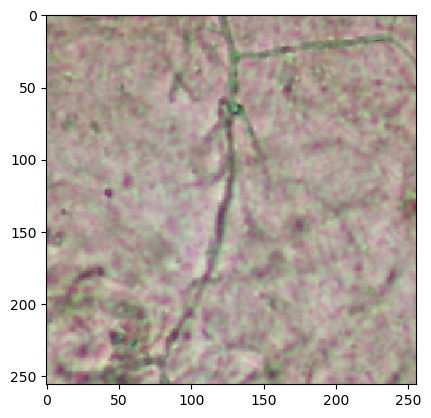

In [51]:
img_1 = img[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]]
plt.imshow(img_1)

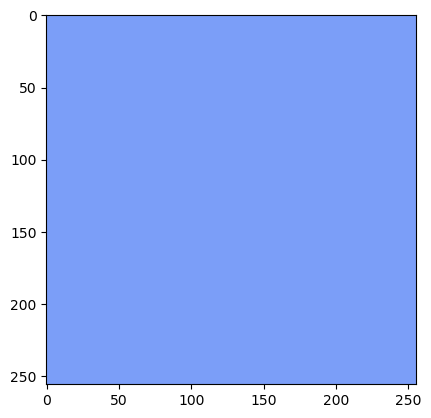

In [86]:
# attention block
# raw_block = overlay[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]]
raw_block = np.ones([256, 256]) * 0.2

# image block (either blank canvas or orig image)
img_block = img[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]].copy()

# color block (cmap applied to attention block)
color_block = (cmap(raw_block) * 255)[:,:,:3].astype(np.uint8)

img_block = color_block

# rewrite image block
# img[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0]] = img_block.copy()

plt.imshow(img_block)

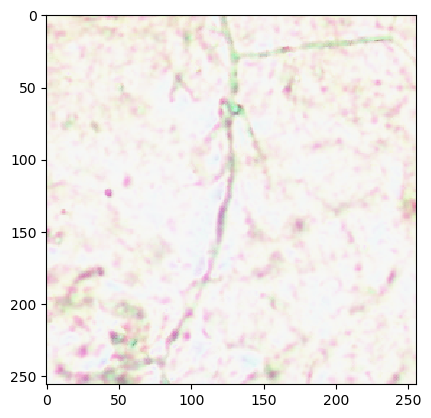

In [80]:
cmap = "coolwarm"
cmap = plt.get_cmap(cmap)

img_2 = (cmap(img_1) * 255)[:,:,:,0].astype(np.uint8)
img_2 = Image.fromarray(img_2)
plt.imshow(img_2)

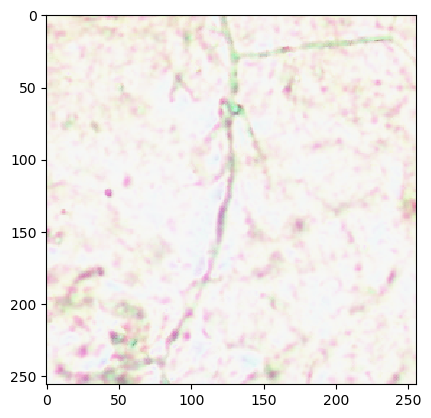

In [77]:
color_block = (cmap(img_1) * 255)[:,:,:,0].astype(np.uint8)
plt.imshow(color_block)

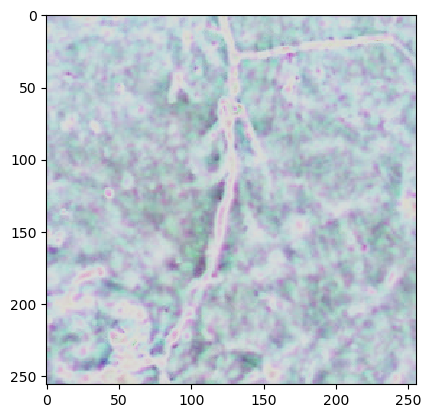

In [78]:
color_block = (cmap(img_1) * 255)[:,:,:,1].astype(np.uint8)
plt.imshow(color_block)

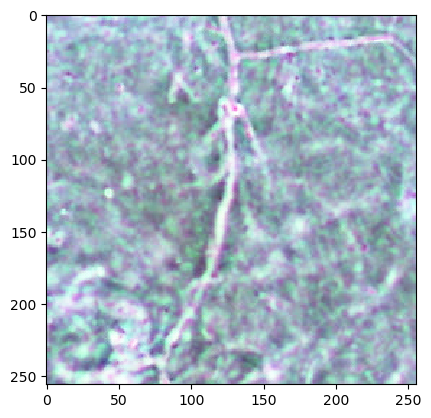

In [79]:
color_block = (cmap(img_1) * 255)[:,:,:,2].astype(np.uint8)
plt.imshow(color_block)

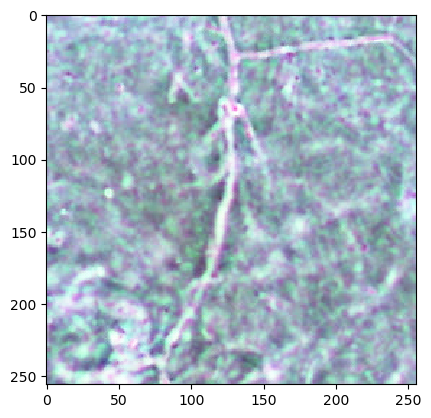

In [76]:
# plt.imshow(img_1, aspect='auto', cmap="coolwarm")

0.5


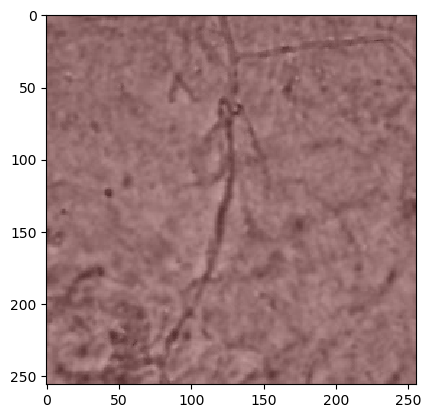

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

score = 0.5
print(score)
threshold = 0.5
if score >= threshold:
    color = (score, 0, 0)
else:
    color = (0, 0, 1-score)
label = np.ones([256, 256])
label = label * score
# print(label)

img_2 = label2rgb(label, image=img_1, colors=[color])
plt.imshow(img_2)

In [35]:
# a = torch.rand([1, 2])
a = torch.Tensor([[-29.9480, -17.3834]])
A = F.softmax(a, dim=1)
print(a)
print(A)

tensor([[-29.9480, -17.3834]])
tensor([[3.4935e-06, 1.0000e+00]])
